In [1]:
import tensorflow as tf
import numpy as np
import os
import time
from scipy import signal
from imageio import imread
from random import shuffle
from matplotlib import pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [40]:
# load_images
    # Read in images and makes a list for each set in the form: [images, labels]
    # images: np array with dims [N x img_height x img width x num_channels]
    # labels: np array with dims [N x 1]. elephant = 0, lionfish = 1
    #
    # Returns:  train_set: The list [train_images, train_labels]
    #           val_set: The list [val_images, val_labels] 

def load_images():
    
    sets = ['train', 'val']
    
    data_sets = []
    for dset in sets:
        img_path = './bin_dataset/' + dset + '/ele'
        ele_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        img_path = './bin_dataset/' + dset + '/lio'
        lio_list = [imread(os.path.join(img_path, img)) for img in os.listdir(img_path)]

        set_images = np.stack(ele_list + lio_list)
        N = set_images.shape[0]
        labels = np.ones((N,1))
        labels[0:int(N/2)] = 0
        data_sets.append([set_images, labels])

    train_set, val_set = data_sets

    print("Loaded", len(train_set[0]), "training images")
    print("Loaded", len(val_set[0]), "validation images")
    
    return train_set, val_set


# batchify
    # Inputs:    train_set: List containing images and labels
    #            batch size: The desired size of each batch
    #
    # Returns:   image_batches: A list of shuffled training image batches, each with size batch_size
    #            label_batches: A list of shuffled training label batches, each with size batch_size 

def batchify(train_set, batch_size):
    
    # YOUR CODE HERE
    # initialized two lists
    image_batches = []
    label_batches = []
    
    shuffle_index = np.arange(len(train_set[0]))
    shuffle(shuffle_index)
    
    image_chunk = [None] * batch_size
    label_chunk = [None] * batch_size
    for c in range(0, len(shuffle_index), batch_size):
        for i in range(batch_size):
            image_chunk[i] = train_set[0][shuffle_index[c+i]]
            label_chunk[i] = train_set[1][shuffle_index[c+i]]
        image_batches.append(np.array(image_chunk))
        label_batches.append(np.array(label_chunk))

    return image_batches, label_batches

def data_transform(data_set):
    data, label = data_set
    data = data.astype(float)
    data /= 256.0
    N = len(data)
    new_label = np.zeros((N, 2)).astype(int)
    new_label[:, 0:1] = (1-label).astype(int)
    new_label[:, 1:2] = label.astype(int)
    return [data, new_label]

In [41]:
# Load images and scale them
# YOUR CODE HERE
train_set, val_set = load_images()
train_set = data_transform(train_set)
val_set = data_transform(val_set)

Loaded 2000 training images
Loaded 800 validation images


In [6]:
# Initialize two constants
x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
print(x1, x2)
# Multiply
result = tf.multiply(x1, x2)

# Print the result
print(result)

Tensor("Const_2:0", shape=(4,), dtype=int32) Tensor("Const_3:0", shape=(4,), dtype=int32)
Tensor("Mul_1:0", shape=(4,), dtype=int32)


In [4]:
# Hyperparameters
epochs = 20
lr = 0.1
image_size = 100
batch_size = 16
filter_len = 5
num_out_ch = 3
mp_len = 12
fc_nodes = 2
W1_len = int((image_size-filter_len+1)/mp_len)
decay = 0.8
# Declare weights
# YOUR CODE HERE
# W0 = np.random.normal(0, 0.05, weights['W0'].shape)
# W1 = np.random.normal(0, 0.05, weights['W1'].shape)
# W2 = np.random.normal(0, 0.05, weights['W2'].shape)
# print(W0.shape)
# print(W1.shape)
# print(W2.shape)
W0 = np.random.normal(0, 0.05, (num_out_ch, filter_len, filter_len, 3))
W1 = np.random.normal(0, 0.05, (W1_len*W1_len*num_out_ch, fc_nodes))
W2 = np.random.normal(0, 0.05, (fc_nodes, 1))

In [27]:
i = tf.reshape(W0, [-1, 5, 5, 3])
print(i)

Tensor("Reshape:0", shape=(3, 5, 5, 3), dtype=float64)


In [23]:
W0 = tf.Variable(W0, name='W0')
W1 = tf.Variable(W1, name='W1')
W2 = tf.Variable(W2, name='W2')
print(W0, W1, W2)

<tf.Variable 'W0_8:0' shape=(3, 5, 5, 3) dtype=float64_ref> <tf.Variable 'W1_2:0' shape=(192, 2) dtype=float64_ref> <tf.Variable 'W2_2:0' shape=(2, 1) dtype=float64_ref>


In [5]:
def cnn_model_fn(N, input_image, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(input_image, [N, 100, 100, 3])
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=3,
        kernel_size=[5, 5],
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=12, strides=12)

    pool1_flat = tf.reshape(pool1, [N, -1])

    # Dense Layer
    dense1 = tf.layers.dense(inputs=pool1_flat, units=2, activation=tf.nn.relu)
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dense1, units=1)
    
    sig = tf.layers.

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten

In [47]:
def cnn_keras(x_train, y_train, batch_size, epochs, x_test, y_test):
    # several steps
    # 1. construct the model
    # 2. compile the model
    # 3. train the model with the input data
    model = Sequential()

    model.add(Conv2D(3, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="valid"))
    model.add(MaxPooling2D(pool_size=(12, 12), strides=(12, 12)))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.1),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=[history])
    
    return model

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))

In [48]:
history = AccuracyHistory()
model = cnn_keras(train_set[0], train_set[1], 16, 20, val_set[0], val_set[1])

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.6718 - acc: 0.5780 - val_loss: 0.4386 - val_acc: 0.8475
Epoch 2/20
2000/2000 [==============================] - 12s 6ms/step - loss: 0.4567 - acc: 0.7910 - val_loss: 0.4488 - val_acc: 0.7837
Epoch 3/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.3176 - acc: 0.8725 - val_loss: 0.2489 - val_acc: 0.8975
Epoch 4/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2687 - acc: 0.8990 - val_loss: 0.3759 - val_acc: 0.8163
Epoch 5/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2557 - acc: 0.9010 - val_loss: 0.3649 - val_acc: 0.8650
Epoch 6/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2381 - acc: 0.9065 - val_loss: 0.2283 - val_acc: 0.9100
Epoch 7/20
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2489 - acc: 0.9050 - val_loss: 0.6103 - val_acc: 0.6950
Epoch 8/

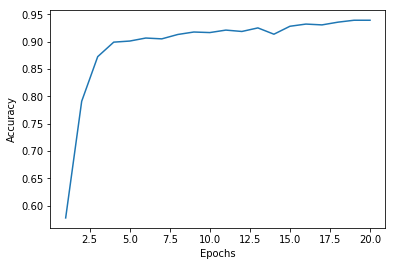

In [49]:
plt.plot(range(1,21), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

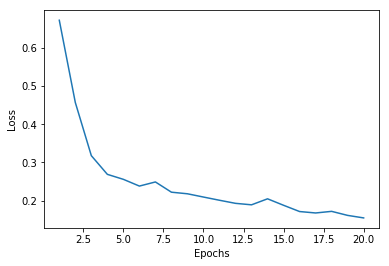

In [50]:
plt.plot(range(1,21), history.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [53]:
score = model.evaluate(train_set[0], train_set[1], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14592011606693267
Test accuracy: 0.941
